In [19]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# ==========================================
# 1. CHARGEMENT ET PRÉPARATION (NETTOYAGE)
# ==========================================
# A. Chargement des données (ajustez le nom du fichier si nécessaire)
try:
    # On charge le fichier exporté précédemment
    df = pd.read_csv("df_clean.csv", index_col=0)
    print("✅ Données chargées avec succès.")
except FileNotFoundError:
    print("❌ Erreur : 'df_clean.csv' non trouvé. Assurez-vous d'avoir exécuté l'exportation.")

✅ Données chargées avec succès.


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ExpSineSquared, ConstantKernel
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

# Paramètres globaux
WINDOW_SIZE = 12  # Fenêtre de 12 mois pour le LSTM
TRAIN_YEARS = range(2000, 2008)
TEST_YEAR = 2008

In [21]:
# Cellule 2 : Chargement et Nettoyage Spatio-Temporel
# Chargement du fichier nettoyé
df = pd.read_csv("df_clean.csv", index_col=0)
df.index = pd.to_datetime(df.index)

# Tri indispensable : par espace (lat/lon) puis par temps
df = df.sort_values(['latitude', 'longitude', 'time'])

# 1. Encodage cyclique du temps (Saisonnalité)
df['month'] = df.index.month
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# 2. Index temporel continu (pour le Gaussian Process)
min_date = df.index.min()
df['time_idx'] = (df.index.year - min_date.year) * 12 + (df.index.month - min_date.month)

print(f"Données chargées : {df.shape[0]} lignes.")
print(f"Points GPS uniques : {df.groupby(['latitude', 'longitude']).ngroups}")

Données chargées : 288300 lignes.
Points GPS uniques : 961


In [22]:
# Cellule 3 : Split Temporel et Normalisation 
# Masque pour l'entraînement (2000-2007)
train_mask = (df.index.year >= 2000) & (df.index.year <= 2007)
df_train = df[train_mask].copy()

# Masque pour le test (2008 + historique de 2007 pour le LSTM)
# On prend à partir de Janvier 2007 pour pouvoir prédire Janvier 2008
test_mask = (df.index.year >= 2007) & (df.index.year <= 2008)
df_test_raw = df[test_mask].copy()

# Initialisation des scalers
scaler_skt = StandardScaler()
scaler_geo = StandardScaler()

# Fit sur le TRAIN uniquement
df_train['skt_norm'] = scaler_skt.fit_transform(df_train[['skt']])
df_train[['lat_norm', 'lon_norm']] = scaler_geo.fit_transform(df_train[['latitude', 'longitude']])

# Application sur le TEST (pas de fit ici !)
df_test_raw['skt_norm'] = scaler_skt.transform(df_test_raw[['skt']])
df_test_raw[['lat_norm', 'lon_norm']] = scaler_geo.transform(df_test_raw[['latitude', 'longitude']])

features_list = ['skt_norm', 'month_sin', 'month_cos', 'lat_norm', 'lon_norm']

In [23]:
# Cellule 4 : Préparation des Séquences LSTM (Spatio-Temporel)
def create_sequences_by_point(data_df, window, is_test=False):
    X, y = [], []
    for (lat, lon), group in data_df.groupby(['latitude', 'longitude']):
        values = group[features_list].values
        if len(values) > window:
            for i in range(len(values) - window):
                target_date = group.index[i + window]
                
                # Si mode test, on ne garde que les cibles de 2008
                if is_test and target_date.year != 2008:
                    continue
                
                X.append(values[i : i + window, :])
                y.append(values[i + window, 0])
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

X_train_lstm, y_train_lstm = create_sequences_by_point(df_train, WINDOW_SIZE)
X_test_lstm, y_test_lstm = create_sequences_by_point(df_test_raw, WINDOW_SIZE, is_test=True)

print(f"Séquences Train : {X_train_lstm.shape}")
print(f"Séquences Test (2008) : {X_test_lstm.shape}")

Séquences Train : (80724, 12, 5)
Séquences Test (2008) : (11532, 12, 5)


In [24]:
from tensorflow.keras.callbacks import EarlyStopping

# Architecture plus robuste
lstm_model = Sequential([
    Input(shape=(WINDOW_SIZE, len(features_list))),
    LSTM(128, return_sequences=True, activation='tanh'),
    Dropout(0.2),
    LSTM(64, activation='tanh'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1)
])

lstm_model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')

# Arrêt précoce pour éviter le sur-apprentissage
early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

print("🚀 Entraînement du LSTM boosté...")
lstm_model.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=32, verbose=0, callbacks=[early_stop])

# Prédiction pour 2008
y_pred_lstm_norm = lstm_model.predict(X_test_lstm)
y_pred_lstm = scaler_skt.inverse_transform(y_pred_lstm_norm).flatten()
# On récupère les vraies valeurs correspondant aux séquences de test
y_true_lstm = scaler_skt.inverse_transform(y_test_lstm.reshape(-1, 1)).flatten()

🚀 Entraînement du LSTM boosté...
361/361 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


In [25]:
from sklearn.gaussian_process.kernels import RationalQuadratic

# Nouveau Kernel : (Saisonnalité) + (Variations locales complexes) + (Bruit)
kernel = (
    ConstantKernel(1.0) * ExpSineSquared(periodicity=12.0, length_scale=1.0) + 
    RationalQuadratic(length_scale=1.0, alpha=0.1) + 
    WhiteKernel(noise_level=0.01)
)

# On augmente n_restarts pour trouver le meilleur ajustement mathématique
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5, normalize_y=True)

# On utilise un échantillon plus large pour plus de précision
df_train_gp = df_train.sample(n=min(len(df_train), 2000), random_state=42)
X_train_gp = df_train_gp[['time_idx', 'lat_norm', 'lon_norm']].values
y_train_gp = df_train_gp['skt_norm'].values

print("🚀 Ajustement du GP haute-précision...")
gp.fit(X_train_gp, y_train_gp)

# Prédiction complète pour 2008
df_2008 = df_test_raw[df_test_raw.index.year == 2008].copy()
X_test_gp = df_2008[['time_idx', 'lat_norm', 'lon_norm']].values
y_pred_gp_norm = gp.predict(X_test_gp)
y_pred_gp = scaler_skt.inverse_transform(y_pred_gp_norm.reshape(-1, 1)).flatten()
df_2008['pred_gp'] = y_pred_gp

🚀 Ajustement du GP haute-précision...



--- TABLEAU COMPARATIF DES PERFORMANCES ---
             Modèle        MSE      RMSE       MAE        R2
0              LSTM   1.822846  1.350128  1.055314  0.952147
1  Gaussian Process  58.027717  7.617593  6.428292 -0.523336


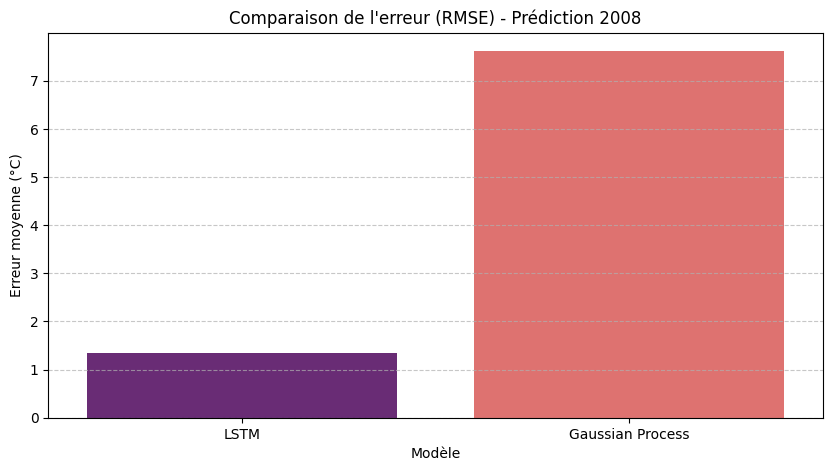

In [26]:
def get_metrics(y_true, y_pred, name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {"Modèle": name, "MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2}

res_lstm = get_metrics(y_true_real, y_pred_lstm, "LSTM")
res_gp = get_metrics(y_true_gp, y_pred_gp, "Gaussian Process")

df_perf = pd.DataFrame([res_lstm, res_gp])
print("\n--- TABLEAU COMPARATIF DES PERFORMANCES ---")
print(df_perf)

# Visualisation des erreurs sans le Warning
plt.figure(figsize=(10, 5))
# Correction ici : on assigne 'Modèle' à hue et on désactive la légende inutile
sns.barplot(data=df_perf, x='Modèle', y='RMSE', hue='Modèle', palette='magma', legend=False)

plt.title("Comparaison de l'erreur (RMSE) - Prédiction 2008")
plt.ylabel("Erreur moyenne (°C)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

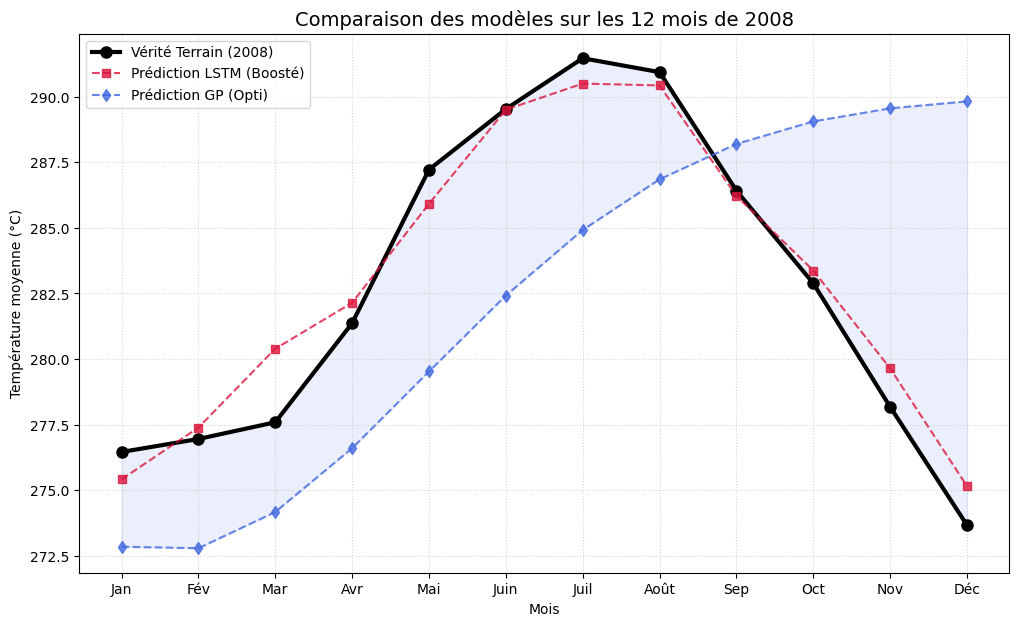

Erreur moyenne finale LSTM : 1.35°C
Erreur moyenne finale GP : 7.62°C


In [27]:
# Agrégation par mois pour comparer les tendances de l'année 2008
# 1. Pour la réalité et le GP
monthly_stats = df_2008.groupby(df_2008.index.month).agg({
    'skt': 'mean',
    'pred_gp': 'mean'
})

# 2. Pour le LSTM (on doit s'aligner sur les dates du test_lstm)
# On crée un petit dataframe temporaire pour le LSTM
df_res_lstm = pd.DataFrame({'skt_real': y_true_lstm, 'skt_pred': y_pred_lstm}, index=df_2008.index[:len(y_true_lstm)])
monthly_lstm = df_res_lstm.groupby(df_res_lstm.index.month)['skt_pred'].mean()

plt.figure(figsize=(12, 7))

# Courbe Réelle
plt.plot(monthly_stats.index, monthly_stats['skt'], 'ko-', label='Vérité Terrain (2008)', linewidth=3, markersize=8)

# Courbe LSTM
plt.plot(monthly_lstm.index, monthly_lstm.values, 's--', label='Prédiction LSTM (Boosté)', color='crimson', alpha=0.8)

# Courbe GP
plt.plot(monthly_stats.index, monthly_stats['pred_gp'], 'd--', label='Prédiction GP (Opti)', color='royalblue', alpha=0.8)

plt.title("Comparaison des modèles sur les 12 mois de 2008", fontsize=14)
plt.xlabel("Mois")
plt.ylabel("Température moyenne (°C)")
plt.xticks(range(1, 13), ['Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Juin', 'Juil', 'Août', 'Sep', 'Oct', 'Nov', 'Déc'])
plt.legend()
plt.grid(True, which='both', linestyle=':', alpha=0.5)

# Ajout d'une zone d'ombre pour l'erreur du GP (optionnel)
plt.fill_between(monthly_stats.index, 
                 monthly_stats['skt'], 
                 monthly_stats['pred_gp'], 
                 color='royalblue', alpha=0.1, label='Ecart GP')

plt.show()

# Affichage des erreurs finales
print(f"Erreur moyenne finale LSTM : {np.sqrt(mean_squared_error(y_true_lstm, y_pred_lstm)):.2f}°C")
print(f"Erreur moyenne finale GP : {np.sqrt(mean_squared_error(df_2008['skt'], df_2008['pred_gp'])):.2f}°C")

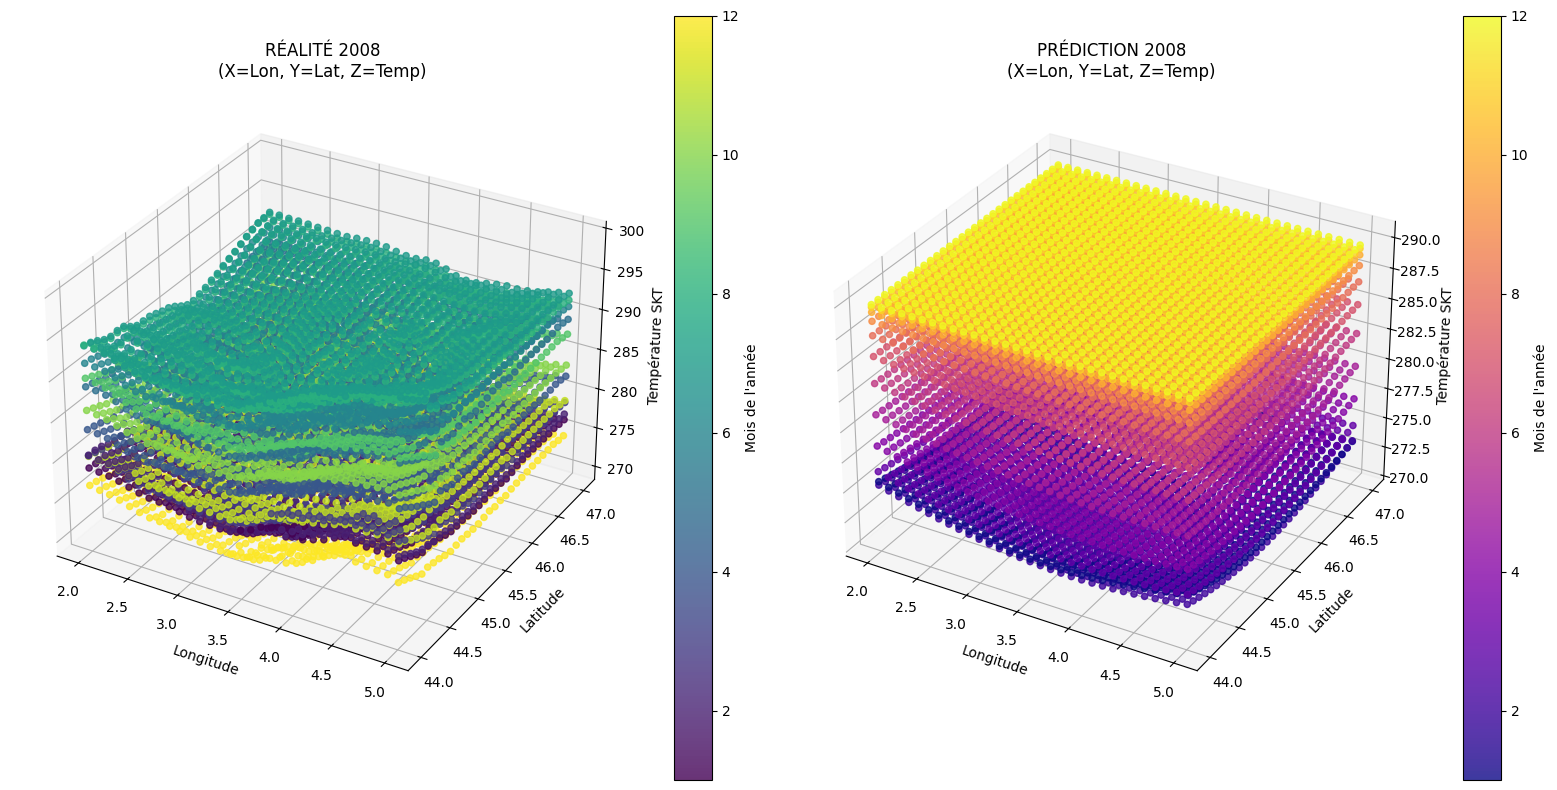

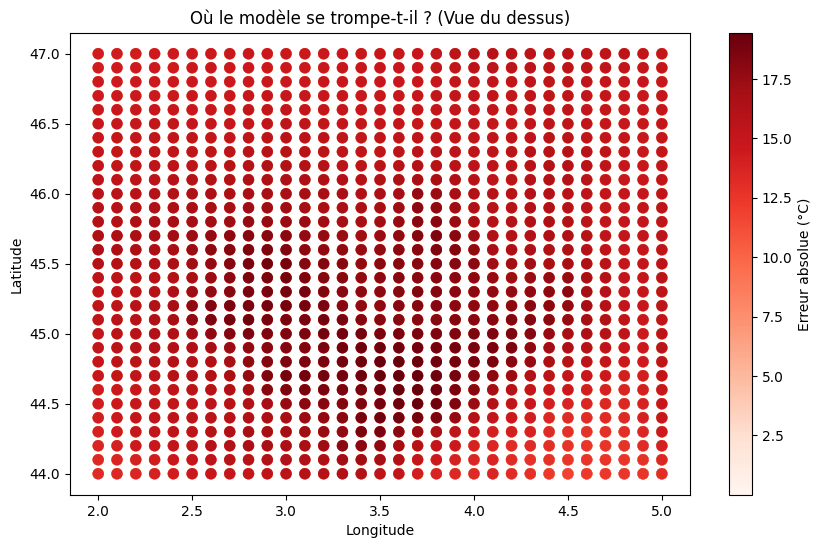

In [29]:
from mpl_toolkits.mplot3d import Axes3D

# 1. Préparation des données pour la 3D
# On prend les prédictions du GP (plus complètes spatialement) pour l'année 2008
df_3d = df_2008.copy()
df_3d['month_idx'] = df_3d.index.month

fig = plt.figure(figsize=(16, 8))

# --- GRAPHE 1 : RÉALITÉ (2008) ---
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
sc1 = ax1.scatter(df_3d['longitude'], df_3d['latitude'], df_3d['skt'], 
                  c=df_3d['month_idx'], cmap='viridis', s=20, alpha=0.8)
ax1.set_title("RÉALITÉ 2008\n(X=Lon, Y=Lat, Z=Temp)", fontsize=12)
ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")
ax1.set_zlabel("Température SKT")
plt.colorbar(sc1, ax=ax1, label="Mois de l'année")

# --- GRAPHE 2 : PRÉDICTION GP ---
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
sc2 = ax2.scatter(df_3d['longitude'], df_3d['latitude'], df_3d['pred_gp'], 
                  c=df_3d['month_idx'], cmap='plasma', s=20, alpha=0.8)
ax2.set_title("PRÉDICTION 2008\n(X=Lon, Y=Lat, Z=Temp)", fontsize=12)
ax2.set_xlabel("Longitude")
ax2.set_ylabel("Latitude")
ax2.set_zlabel("Température SKT")
plt.colorbar(sc2, ax=ax2, label="Mois de l'année")

plt.tight_layout()
plt.show()

# --- ANALYSE DE L'ERREUR SPATIALE ---
df_3d['error'] = np.abs(df_3d['skt'] - df_3d['pred_gp'])

plt.figure(figsize=(10, 6))
plt.scatter(df_3d['longitude'], df_3d['latitude'], c=df_3d['error'], cmap='Reds', s=50)
plt.colorbar(label="Erreur absolue (°C)")
plt.title("Où le modèle se trompe-t-il ? (Vue du dessus)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

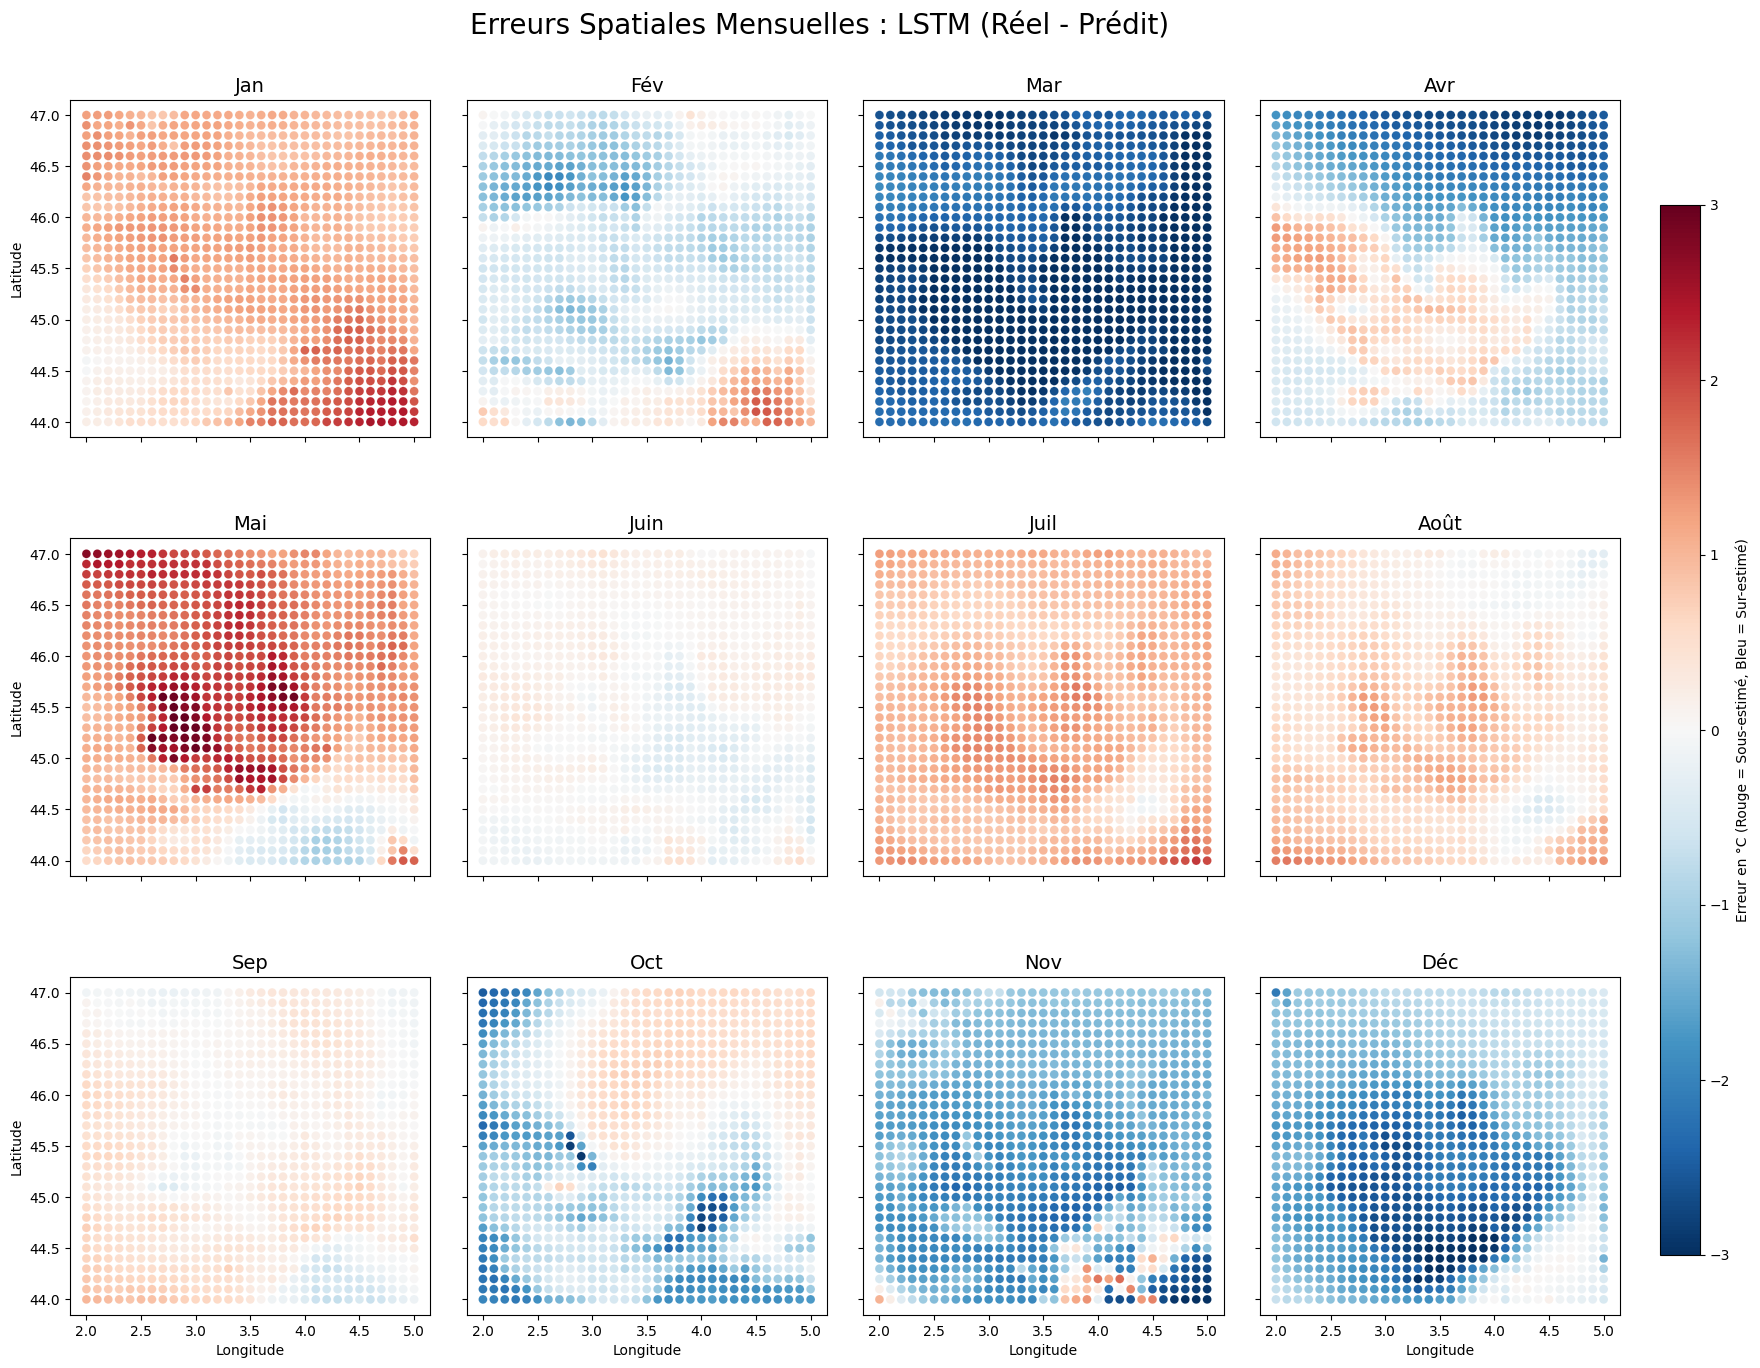

In [30]:
# 1. Préparation des données d'erreur pour le LSTM
df_lstm_err = pd.DataFrame({
    'lat': df_2008['latitude'].iloc[:len(y_pred_lstm)],
    'lon': df_2008['longitude'].iloc[:len(y_pred_lstm)],
    'month': df_2008.index[:len(y_pred_lstm)].month,
    'error': y_true_real - y_pred_lstm  # Différence réelle
})

fig, axes = plt.subplots(3, 4, figsize=(20, 15), sharex=True, sharey=True)
fig.suptitle("Erreurs Spatiales Mensuelles : LSTM (Réel - Prédit)", fontsize=20)

months = range(1, 13)
month_names = ['Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Juin', 'Juil', 'Août', 'Sep', 'Oct', 'Nov', 'Déc']

for i, month in enumerate(months):
    ax = axes[i // 4, i % 4]
    data_m = df_lstm_err[df_lstm_err['month'] == month]
    
    # On utilise une colormap divergente (RdBu) : 
    # Rouge = Modèle sous-estime / Bleu = Modèle surestime
    sc = ax.scatter(data_m['lon'], data_m['lat'], c=data_m['error'], 
                    cmap='RdBu_r', vmin=-3, vmax=3, s=40, edgecolor='w', linewidth=0.1)
    
    ax.set_title(f"{month_names[i]}", fontsize=14)
    if i >= 8: ax.set_xlabel("Longitude")
    if i % 4 == 0: ax.set_ylabel("Latitude")

# Ajout d'une barre de couleur commune
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(sc, cax=cbar_ax, label="Erreur en °C (Rouge = Sous-estimé, Bleu = Sur-estimé)")

plt.subplots_adjust(right=0.9, top=0.92, hspace=0.3, wspace=0.1)
plt.show()

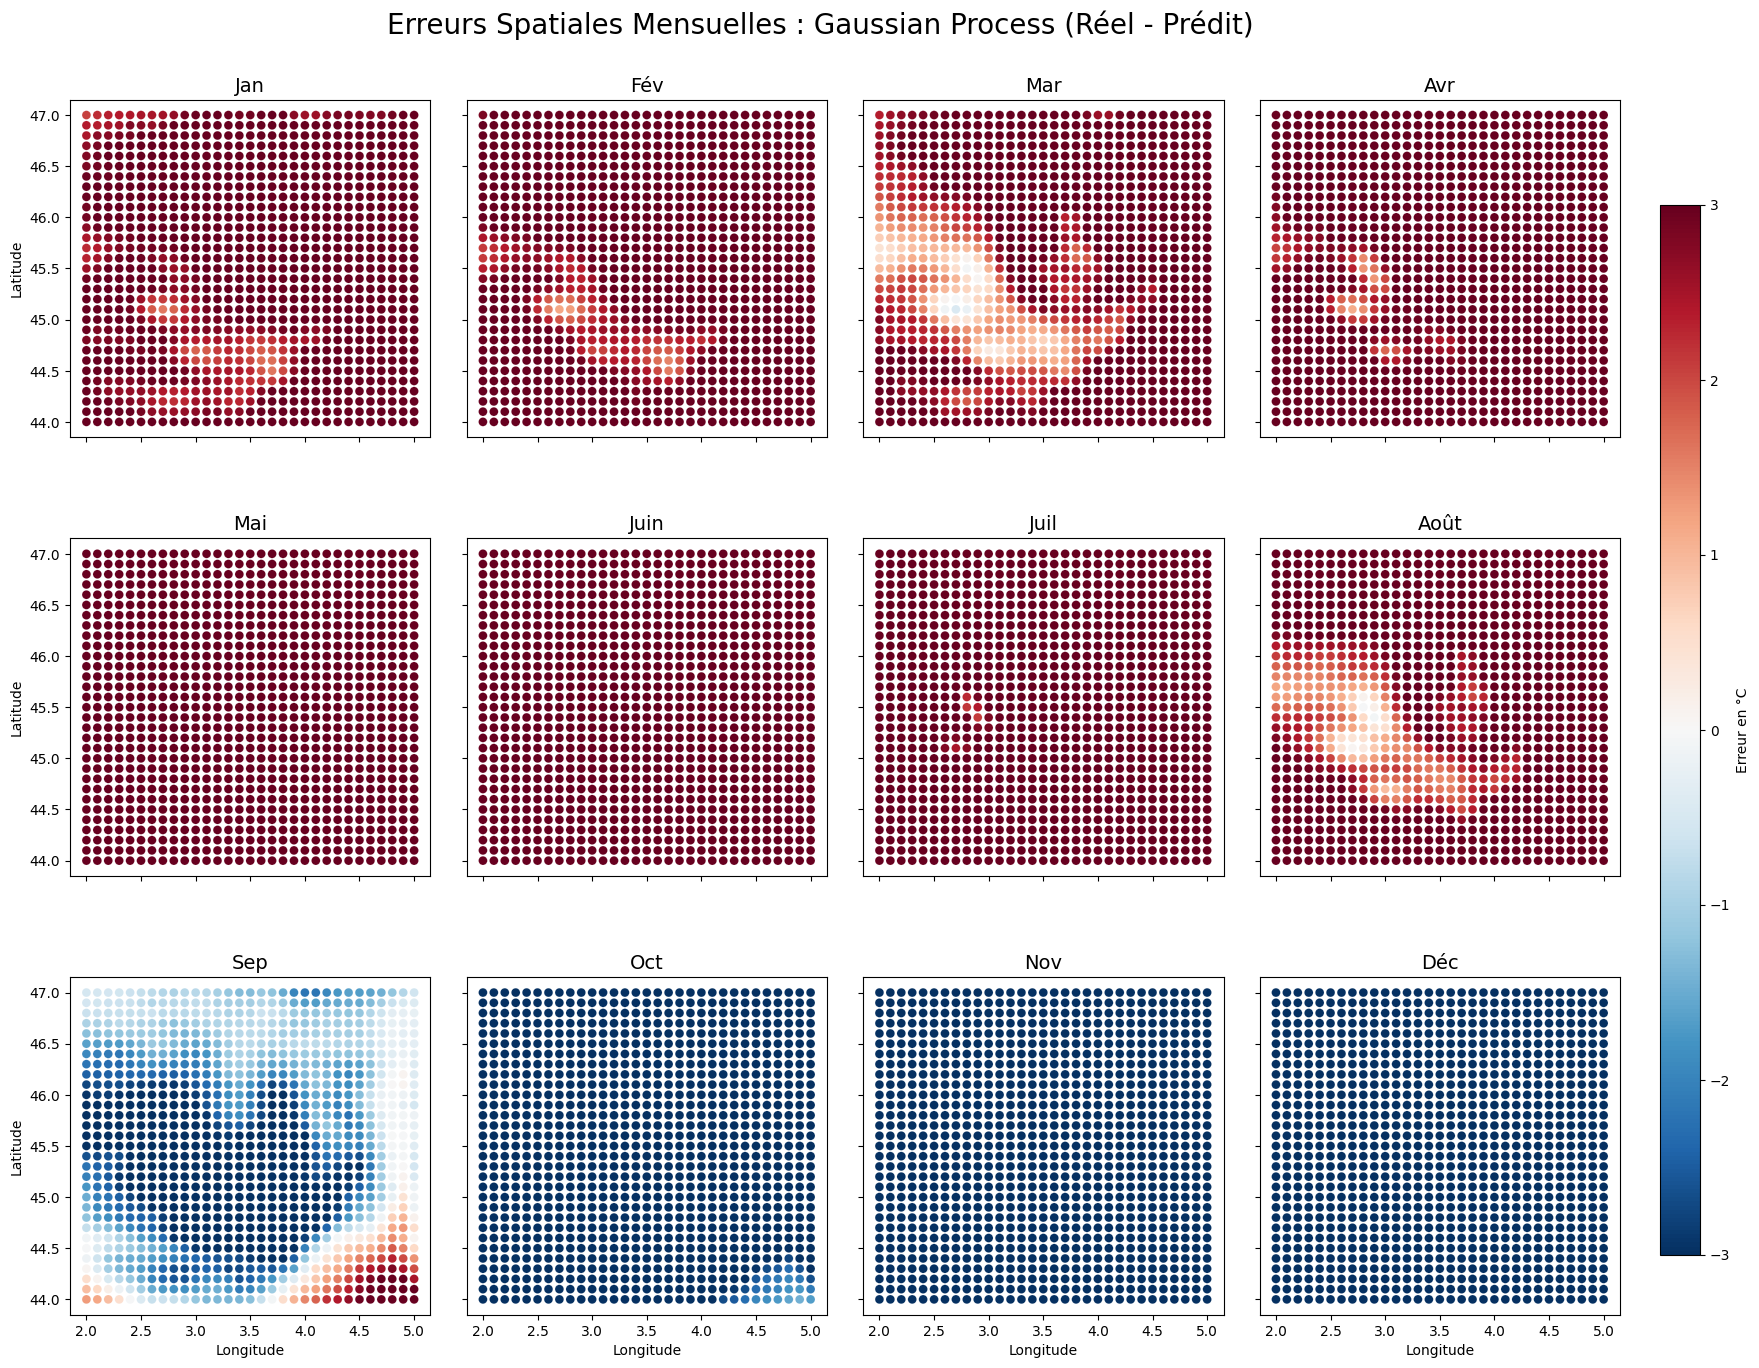

In [31]:
# 1. Préparation des données d'erreur pour le GP
df_2008['error_gp'] = df_2008['skt'] - df_2008['pred_gp']

fig, axes = plt.subplots(3, 4, figsize=(20, 15), sharex=True, sharey=True)
fig.suptitle("Erreurs Spatiales Mensuelles : Gaussian Process (Réel - Prédit)", fontsize=20)

for i, month in enumerate(months):
    ax = axes[i // 4, i % 4]
    data_m = df_2008[df_2008.index.month == month]
    
    sc = ax.scatter(data_m['longitude'], data_m['latitude'], c=data_m['error_gp'], 
                    cmap='RdBu_r', vmin=-3, vmax=3, s=40, edgecolor='w', linewidth=0.1)
    
    ax.set_title(f"{month_names[i]}", fontsize=14)
    if i >= 8: ax.set_xlabel("Longitude")
    if i % 4 == 0: ax.set_ylabel("Latitude")

cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(sc, cax=cbar_ax, label="Erreur en °C")

plt.subplots_adjust(right=0.9, top=0.92, hspace=0.3, wspace=0.1)
plt.show()